In [ ]:
# ===== Initialize Environment =====
import os, sys

# 1. Clone the repository if it does not exist
if not os.path.exists('/content/AdvPFY'):
    !git clone https://github.com/GoL2022/AdvPFY.git /content/AdvPFY

# 2. Enter the project directory
%cd /content/AdvPFY

# 3. Install dependencies (only needed for the first run)
!pip install -r requirements.txt

# 4. Ensure Python can correctly import internal project modules
if '/content/AdvPFY' not in sys.path:
    sys.path.append('/content/AdvPFY')

# 5. Print confirmation
print("✅ Current working directory:", os.getcwd())
!ls -la

/content/AdvPFY
✅ 当前工作目录： /content/AdvPFY
total 1032
drwxr-xr-x 5 root root   4096 Oct 20 06:36 .
drwxr-xr-x 1 root root   4096 Oct 20 06:35 ..
-rw-r--r-- 1 root root  14262 Oct 20 06:35 CIFAR10_ResNet.ipynb
drwxr-xr-x 3 root root   4096 Oct 20 06:36 data
drwxr-xr-x 8 root root   4096 Oct 20 06:35 .git
drwxr-xr-x 3 root root   4096 Oct 20 06:36 model
-rw-r--r-- 1 root root   5191 Oct 20 06:35 pgd_purify.py
-rw-r--r-- 1 root root 917438 Oct 20 06:35 purify_attack_demo.ipynb
-rw-r--r-- 1 root root   2942 Oct 20 06:35 README.md
-rw-r--r-- 1 root root    102 Oct 20 06:35 requirements.txt
-rw-r--r-- 1 root root  84043 Oct 20 06:35 training_demo.ipynb


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from model.nn_model import VAEClassifier, StAEClassifier

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 256
epoch_num = 32 # small epoch number for demo
classification_weight = 8
lr = 1e-4

In [ ]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])), batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
vae_classifier = VAEClassifier()
stae_classifier = StAEClassifier()
vae_classifier = vae_classifier.to(device)
stae_classifier = stae_classifier.to(device)

In [ ]:
CE_Loss = nn.CrossEntropyLoss()
mseloss = torch.nn.MSELoss()
optimizer1 = torch.optim.Adam(vae_classifier.parameters(), lr=lr)
optimizer2 = torch.optim.Adam(stae_classifier.parameters(), lr=lr)

In [ ]:
for epoch in range(epoch_num):
    vae_classifier.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        x_reconst, z, y, mu, log_var = vae_classifier(data, deterministic=False, classification_only=False)
        recons_loss = torch.sum((x_reconst - data) ** 2)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp())
        # jointly training
        loss_val = CE_Loss(y, target) * classification_weight * batch_size + recons_loss + kld_loss
        optimizer1.zero_grad()
        loss_val.backward()
        optimizer1.step()

vae_classifier.eval()
torch.save(vae_classifier.state_dict(), './model/vae_clf.pth')

In [ ]:
for epoch in range(epoch_num):
    stae_classifier.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        x_reconst, z, y = stae_classifier(data, classification_only=False)
        loss_val = CE_Loss(y, target) * classification_weight * batch_size + torch.sum((x_reconst - data) ** 2)
        optimizer2.zero_grad()
        loss_val.backward()
        optimizer2.step()

stae_classifier.eval()
torch.save(stae_classifier.state_dict(), './model/stae_clf.pth')

# Evaluation on testing data

In [ ]:
vae_classifier = vae_classifier.eval()
stae_classifier = stae_classifier.eval()
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),])), batch_size=batch_size, shuffle=False, num_workers=4)

# Standard-AE-Classifier

In [ ]:
pred_list = []
gt_list = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    x_reconst, z, y_test = stae_classifier(data, classification_only=False)
    pred_list += list(y_test.argmax(-1).cpu().detach().numpy())
    gt_list += list(target.detach().cpu().numpy())

acc = np.sum(np.array(gt_list) == np.array(pred_list)) / len(gt_list)
print(acc)

0.9163


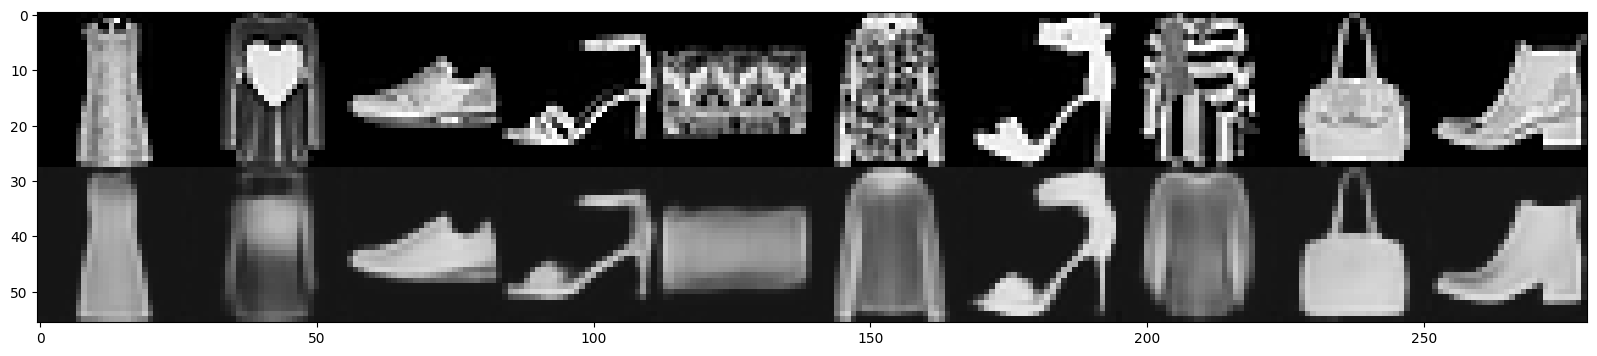

In [ ]:
plt.figure(figsize=(20,5))
reconst_sample = np.concatenate(x_reconst[:10,0].detach().cpu().numpy(), axis=1)
input_sample = np.concatenate(data[:10,0].detach().cpu().numpy(), axis=1)
plt.imshow(np.concatenate([input_sample, reconst_sample], axis=0), cmap='gray')
plt.show()

# VAE-Classifier

In [ ]:
pred_list = []
gt_list = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    x_reconst, z, y_test, mu, log_var = vae_classifier(data, deterministic=True, classification_only=False)
    pred_list += list(y_test.argmax(-1).cpu().detach().numpy())
    gt_list += list(target.detach().cpu().numpy())

acc = np.sum(np.array(gt_list) == np.array(pred_list)) / len(gt_list)
print(acc)

0.9098


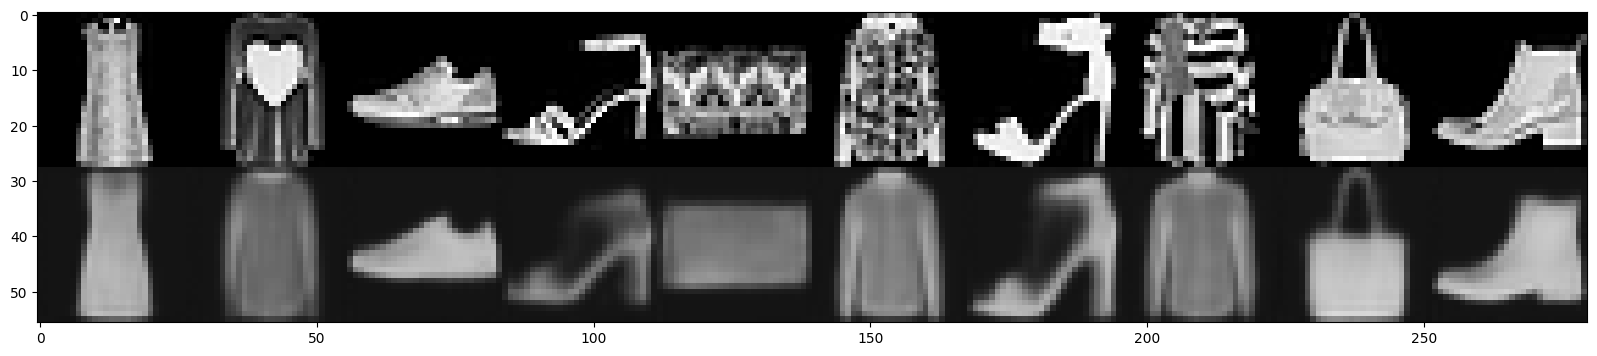

In [ ]:
plt.figure(figsize=(20,5))
reconst_sample = np.concatenate(x_reconst[:10,0].detach().cpu().numpy(), axis=1)
input_sample = np.concatenate(data[:10,0].detach().cpu().numpy(), axis=1)
plt.imshow(np.concatenate([input_sample, reconst_sample], axis=0), cmap='gray')
plt.show()

Download the generated model files vae_clf.pth and stae_clf.pth.